# UCR Dataset: ECG200

**Dataset Homepage:** https://timeseriesclassification.com/description.php?Dataset=ECG200.

### 1. Environment set-up

1. This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. Some hands-on experience using [Amazon SageMaker](https://aws.amazon.com/sagemaker/).
1. To use this algorithm successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to the [Time Series Clustering (CNN-KMeans) Algorithm from AWS Marketplace](https://aws.amazon.com/marketplace/pp/prodview-3hdblqdz5nx4m).

To subscribe to the algorithm:
1. Open the algorithm listing page.
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you agree with EULA, pricing, and support terms. 
1. Once you click on the **Continue to configuration** button and then choose a **region**, you will see a **Product ARN**. This is the algorithm ARN that you need to specify while training a custom ML model. **Copy the ARN corresponding to your region and specify the same in the following cell.**

In [1]:
algo_arn = "arn:aws:sagemaker:eu-west-1:661670223746:algorithm/cnn-kmeans-algo-v1-2"

In [2]:
import sagemaker
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

# SageMaker session
sagemaker_session = sagemaker.Session()

# SageMaker role
role = sagemaker.get_execution_role()

# S3 bucket
bucket = sagemaker_session.default_bucket()

# EC2 instance
instance_type = "ml.m5.2xlarge"

### 2. Data preparation

#### 2.1 Training dataset

Load the training data.

In [3]:
training_dataset = pd.DataFrame(data=np.genfromtxt("ECG200_TRAIN.txt"))

In [4]:
training_dataset.shape

(100, 97)

In [5]:
training_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,-1.0,0.502055,0.542163,0.722383,1.428885,2.136516,2.281149,1.936274,1.468890,1.008845,...,0.931043,0.610298,0.638894,0.684679,0.583238,0.640522,0.708585,0.705011,0.713815,0.433765
1,1.0,0.147647,0.804668,0.367771,0.243894,0.026614,-0.274402,0.096731,-0.747731,-1.609777,...,-0.533503,-0.400228,0.176084,1.111768,2.438428,2.734889,1.736054,0.036857,-1.265074,-0.208024
2,-1.0,0.316646,0.243199,0.370471,1.063738,1.678187,1.759558,1.697717,1.612159,1.168188,...,0.764229,0.610621,0.552900,0.566786,0.604002,0.777068,0.812345,0.748848,0.818042,0.539347
3,-1.0,1.168874,2.075901,1.760141,1.606446,1.949046,1.302842,0.459332,0.516412,0.852180,...,0.419006,0.723888,1.323947,2.136488,1.746597,1.470220,1.893512,1.256949,0.800407,0.731540
4,1.0,0.648658,0.752026,2.636231,3.455716,2.118157,0.520620,-0.188627,0.780818,0.933775,...,-0.097869,-0.136787,-0.340237,-0.089441,-0.080297,-0.192584,-0.304704,-0.454556,0.314590,0.582190


In [6]:
training_dataset.iloc[:, 0].sort_values().unique()

array([-1.,  1.])

In [7]:
training_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

-1.0    31
 1.0    69
Name: count, dtype: int64

Visualize the training data.

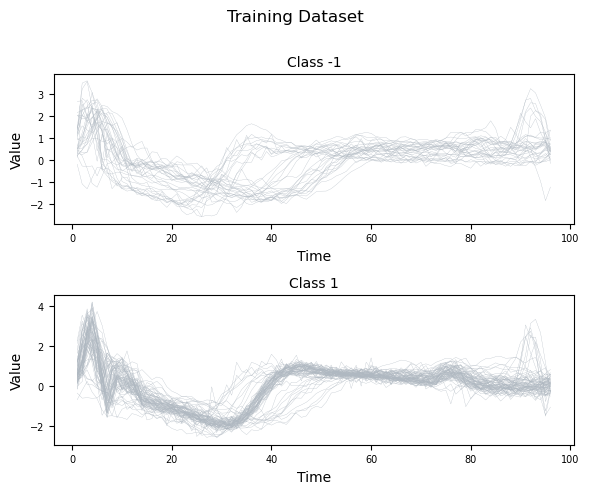

In [8]:
fig, axs = plt.subplots(nrows=training_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 5))
for i, c in enumerate(training_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(training_dataset[training_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.2)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Training Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.show()

Upload the training data to S3, make sure to remove the first column with the class labels.

In [9]:
training_data = sagemaker_session.upload_string_as_file_body(
    body=training_dataset.iloc[:, 1:].to_csv(index=False, header=False),
    bucket=bucket,
    key="ECG200_train.csv"
)

In [10]:
training_data

's3://sagemaker-eu-west-1-661670223746/ECG200_train.csv'

#### 2.2 Test dataset

Load the test data.

In [11]:
test_dataset = pd.DataFrame(data=np.genfromtxt("ECG200_TEST.txt"))

In [12]:
test_dataset.shape

(100, 97)

In [13]:
test_dataset.head()

,0,1,2,3,4,5,6,7,8,9,...,87,88,89,90,91,92,93,94,95,96
0,1.0,0.425189,1.418599,2.668791,3.298629,2.264554,0.165179,-0.959727,0.282668,0.842850,...,-0.018196,-0.220493,-0.152557,-0.117011,-0.145160,-0.116668,-0.199262,-0.109837,-0.142488,0.098758
1,1.0,0.653929,2.177290,3.644783,2.279203,0.978367,-0.388296,-0.911911,-0.148330,0.305439,...,0.099883,0.141395,-0.239092,0.247424,-0.085150,0.007800,0.407868,-0.194915,0.171107,0.197027
2,1.0,0.404953,0.553996,0.724097,1.449039,2.012616,1.624477,1.204726,1.117511,0.562099,...,1.297938,1.243332,1.463616,1.694916,1.456115,1.570372,1.934584,1.497556,0.812570,0.390639
3,1.0,1.088088,2.011949,2.301733,1.630199,0.636768,-0.140502,0.547954,1.075071,0.896861,...,0.125239,0.071349,0.138197,0.116399,0.131198,0.119412,0.082968,0.151348,0.273915,0.349405
4,-1.0,0.443621,0.947285,1.924084,2.159790,1.499447,0.964508,0.223256,-0.424946,0.121279,...,0.900511,1.278688,2.317878,2.916254,2.211947,2.034753,2.071302,1.254178,1.037879,1.009615


In [14]:
test_dataset.iloc[:, 0].sort_values().unique()

array([-1.,  1.])

In [15]:
test_dataset.iloc[:, 0].rename(None).value_counts().sort_index()

-1.0    36
 1.0    64
Name: count, dtype: int64

Visualize the test data.

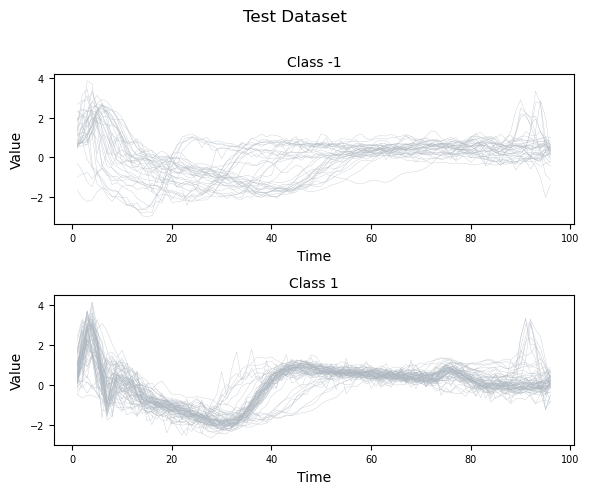

In [16]:
fig, axs = plt.subplots(nrows=test_dataset.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 5))
for i, c in enumerate(test_dataset.iloc[:, 0].sort_values().unique()):
    axs[i].plot(test_dataset[test_dataset.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.2)
    axs[i].set_title(f"Class {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Test Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.show()

Upload the test data to S3, make sure to remove the first column with the class labels.

In [17]:
test_data = sagemaker_session.upload_string_as_file_body(
    body=test_dataset.iloc[:, 1:].to_csv(index=False, header=False),
    bucket=bucket,
    key="ECG200_test.csv"
)

In [18]:
test_data

's3://sagemaker-eu-west-1-661670223746/ECG200_test.csv'

### 3. Training

Fit the model to the training data.

In [19]:
estimator = sagemaker.algorithm.AlgorithmEstimator(
    algorithm_arn=algo_arn,
    role=role,
    instance_count=1,
    instance_type=instance_type,
    input_mode="File",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        "clusters": 2,
        "algorithm": "lloyd",
        "blocks": 10,
        "filters": 40,
        "kernel-size": 3,
        "reduced-size": 160,
        "output-size": 320,
        "negative-samples": 5,
        "lr": 0.001,
        "batch-size": 50,
        "epochs": 10,
    },
)

estimator.fit({"training": training_data})

INFO:sagemaker:Creating training-job with name: cnn-kmeans-algo-v1-2-2023-08-18-10-54-37-541


2023-08-18 10:54:37 Starting - Starting the training job...
2023-08-18 10:54:53 Starting - Preparing the instances for training......
2023-08-18 10:56:05 Downloading - Downloading input data
2023-08-18 10:56:05 Training - Downloading the training image.....................
2023-08-18 10:59:31 Training - Training image download completed. Training in progress.....bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-08-18 11:00:04,859 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-08-18 11:00:04,860 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-08-18 11:00:04,861 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-08-18 11:00:04,861 sagemaker-training-toolkit INFO     Failed to parse hyperparameter algorithm value lloyd to Json.
Returning the value itself
2023-08-18 11:00:04,870 sagemaker_pyto

### 4. Inference

Generate the test set predictions.

In [20]:
transformer = estimator.transformer(
    instance_count=1,
    instance_type=instance_type,
    max_payload=100,
)

transformer.transform(
    data=test_data,
    content_type="text/csv",
)

INFO:sagemaker:Creating model package with name: cnn-kmeans-algo-v1-2-2023-08-18-11-01-53-506


.........

INFO:sagemaker:Creating model with name: cnn-kmeans-algo-v1-2-2023-08-18-11-01-5-2023-08-18-11-02-38-984


INFO:sagemaker:Creating transform job with name: cnn-kmeans-algo-v1-2-2023-08-18-11-02-39-811


..........................................
2023-08-18T11:09:39,621 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-08-18T11:09:39,691 [INFO ] main org.pytorch.serve.metrics.configuration.MetricConfiguration - Successfully loaded metrics configuration from /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
2023-08-18T11:09:39,791 [INFO ] main org.pytorch.serve.ModelServer - 
Torchserve version: 0.8.1
TS Home: /opt/conda/lib/python3.10/site-packages
Current directory: /
Temp directory: /home/model-server/tmp
Metrics config path: /opt/conda/lib/python3.10/site-packages/ts/configs/metrics.yaml
Number of GPUs: 0
Number of CPUs: 8
Max heap size: 7924 M
Python executable: /opt/conda/bin/python3.10
Config file: /etc/sagemaker-ts.properties
Inference address: http://0.0.0.0:8080
2023-08-18T11:09:39,621 [INFO ] main org.pytorch.serve.servingsdk.impl.PluginsManager - Initializing plugins manager...
2023-08-18T11:09:39,691 [INFO ] m

Load the test set predictions from S3.

In [21]:
predictions = sagemaker_session.read_s3_file(
    bucket=bucket,
    key_prefix=f"{transformer.latest_transform_job.name}/ECG200_test.csv.out"
)

In [22]:
predictions = pd.DataFrame([x.split(",") for x in predictions.split("\n")[:-1]]).replace("", np.nan).astype(float)

In [23]:
predictions.shape

(100, 321)

In [24]:
predictions.head()

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,0.0,0.038510,-0.034822,0.037377,0.137938,-0.012916,0.009936,0.031974,0.026103,-0.028697,...,0.036053,0.011775,0.134962,-0.047656,-0.026792,0.010712,-0.055792,-0.001545,0.040507,-0.096711
1,0.0,0.038568,0.008257,0.111194,0.034415,0.003262,-0.050770,0.082673,-0.011328,-0.061240,...,0.018909,-0.005764,0.058528,-0.089091,-0.042481,-0.030142,-0.046527,-0.062727,0.006122,-0.107324
2,1.0,0.001166,-0.047702,0.027501,0.106676,0.048232,0.098108,0.025335,0.031633,-0.061570,...,0.038459,0.008471,0.149810,-0.080856,-0.148172,0.063882,-0.052397,-0.043799,0.067698,-0.056116
3,0.0,0.025679,0.001238,-0.003285,0.111381,0.018252,0.052874,0.016274,-0.004542,-0.060174,...,-0.003184,0.018470,0.115817,-0.052505,-0.045253,0.021869,0.037409,-0.028452,0.020532,-0.102831
4,1.0,-0.021146,-0.139102,0.136712,0.211526,0.240930,0.238958,-0.006766,0.080523,-0.262415,...,-0.003383,-0.097072,0.252138,-0.166328,-0.310025,0.259002,-0.097721,-0.104248,-0.027520,-0.101871


In [25]:
predictions.iloc[:, 0].sort_values().unique()

array([0., 1.])

In [26]:
predictions.iloc[:, 0].rename(None).value_counts().sort_index()

0.0    57
1.0    43
Name: count, dtype: int64

Calculate the Silhouette Coefficient.

In [27]:
silhouette_score(X=predictions.iloc[:, 1:], labels=predictions.iloc[:, 0])

0.3659146742287503

Visualize the results.

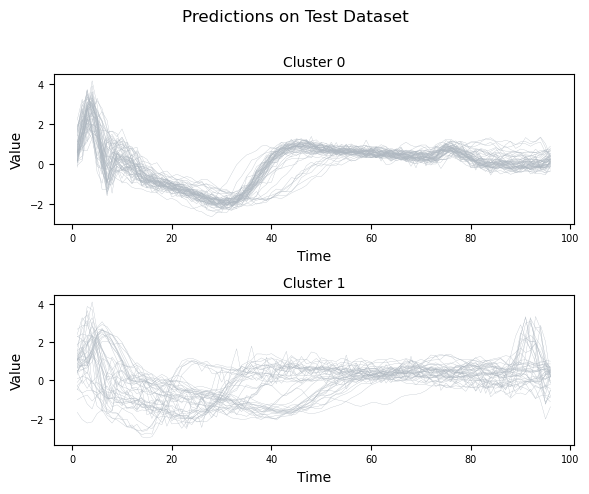

In [28]:
fig, axs = plt.subplots(nrows=predictions.iloc[:, 0].nunique(), ncols=1, sharex=True, figsize=(6, 5))
for i, c in enumerate(predictions.iloc[:, 0].sort_values().unique()):
    axs[i].plot(test_dataset[predictions.iloc[:, 0] == c].iloc[:, 1:].transpose(), color="#AFB8C1", lw=0.2)
    axs[i].set_title(f"Cluster {int(c)}", size=10)
    axs[i].set(xlabel="Time", ylabel="Value")
    axs[i].xaxis.set_tick_params(labelbottom=True)
    axs[i].tick_params(axis="both", which="major", labelsize=7)
    axs[i].tick_params(axis="both", which="minor", labelsize=7)
fig.suptitle("Predictions on Test Dataset")
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.show()